In [1]:
# 2.4 fixed v2 — метод сращивания (matched asymptotics) + численно
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

# Задача: ε y'' + (2x+1) y' + 2 y = 0,  x∈[0,1],  y(0)=A,  y(1)=B,  ε ≪ 1

# Композитное (сращённое) решение: outer + (inner - overlap)
# Внешнее: y_out(x) = C/(2x+1),  из y(1)=B ⇒ C = 3B
# Внутреннее у x=0: ζ = x/ε,  y_in(ζ) = 3B + (A-3B) e^{-ζ}
# Композит: y_comp(x) = y_out(x) + (A - 3B) * exp(-x/eps)

def y_comp(x, eps, A, B):
    return 3.0 * B / (2.0 * x + 1.0) + (A - 3.0 * B) * np.exp(-x / eps)

# SciPy: решение краевой задачи

def solve_scipy(eps, A, B, N=800):
    def ode_system(x, y):
        y1, y2 = y
        return np.vstack((
            y2,
            -((2.0 * x + 1.0) * y2 + 2.0 * y1) / eps
        ))

    def bc(ya, yb):
        return np.array([ya[0] - A, yb[0] - B])

    x = np.linspace(0.0, 1.0, N)
    y_guess = np.zeros((2, x.size))
    sol = solve_bvp(ode_system, bc, x, y_guess)
    return sol.x, sol.y[0]

# Прогонка (центральные разности): ε y'' + (2x+1) y' + 2 y = 0
# y'' ≈ (y_{i+1} - 2 y_i + y_{i-1})/dx^2,  y' ≈ (y_{i+1} - y_{i-1})/(2 dx)
# A_i y_{i-1} + B_i y_i + C_i y_{i+1} = 0,  A_i = ε/dx^2 - (2x_i+1)/(2dx),
# B_i = -2ε/dx^2 + 2,  C_i = ε/dx^2 + (2x_i+1)/(2dx)

def solve_progonka(eps, A, B, N=2000):
    x = np.linspace(0.0, 1.0, N + 1)
    dx = x[1] - x[0]

    a = np.zeros(N - 1)
    b = np.zeros(N - 1)
    c = np.zeros(N - 1)
    d = np.zeros(N - 1)

    for i in range(1, N):
        xi = x[i]
        Ai = eps / dx**2 - (2.0 * xi + 1.0) / (2.0 * dx)
        Bi = -2.0 * eps / dx**2 + 2.0
        Ci = eps / dx**2 + (2.0 * xi + 1.0) / (2.0 * dx)
        a[i - 1] = Ai
        b[i - 1] = Bi
        c[i - 1] = Ci
        d[i - 1] = 0.0

    # Учёт граничных условий y0=A, yN=B
    d[0] -= a[0] * A
    a[0] = 0.0
    d[-1] -= c[-1] * B
    c[-1] = 0.0

    # Томас (прогонка) для внутренней системы (N-1 неизвестных: y1..y_{N-1})
    cp = np.zeros(N - 1)
    dp = np.zeros(N - 1)
    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]
    for i in range(1, N - 1):
        denom = b[i] - a[i] * cp[i - 1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i] * dp[i - 1]) / denom

    y_inner = np.zeros(N - 1)
    y_inner[-1] = dp[-1]
    for i in range(N - 3, -1, -1):
        y_inner[i] = dp[i] - cp[i] * y_inner[i + 1]

    y = np.zeros(N + 1)
    y[0] = A
    y[-1] = B
    y[1:N] = y_inner

    return x, y


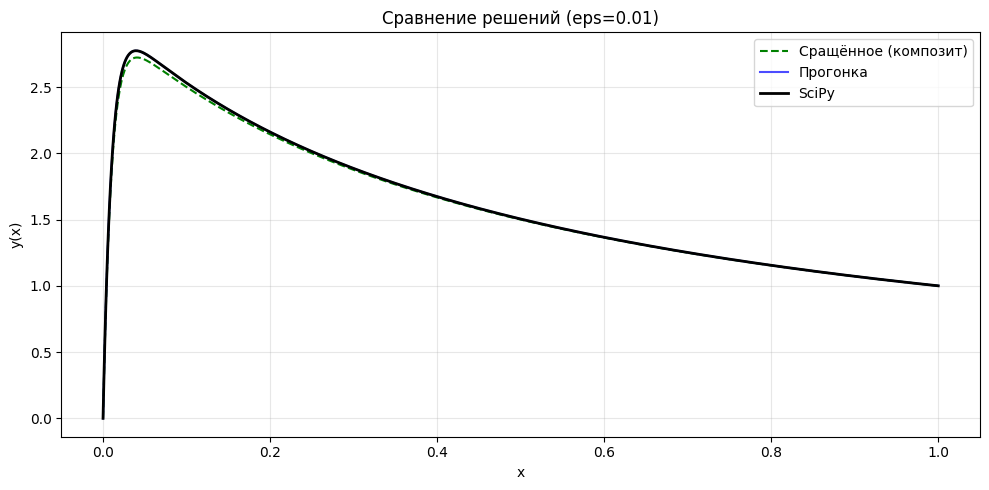

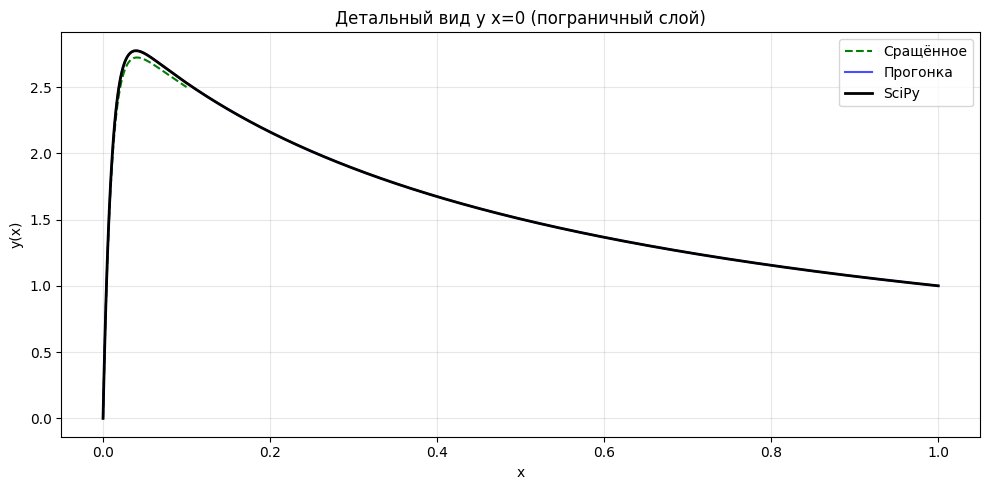

In [2]:
# Параметры и демонстрация
A, B = 0.0, 1.0
EPS = 1e-2

x_sci, y_sci = solve_scipy(EPS, A, B)
x_num, y_num = solve_progonka(EPS, A, B, N=4000)

X = np.linspace(0.0, 1.0, 1000)
y_cmp = y_comp(X, EPS, A, B)

plt.figure(figsize=(10, 5))
plt.plot(X, y_cmp, 'g--', label='Сращённое (композит)')
plt.plot(x_num, y_num, 'b-', alpha=0.7, label='Прогонка')
plt.plot(x_sci, y_sci, 'k-', linewidth=2, label='SciPy')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title(f'Сравнение решений (eps={EPS})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom около x=0 (пограничный слой)
Xz = np.linspace(0.0, 0.1, 400)
y_cmp_z = y_comp(Xz, EPS, A, B)

plt.figure(figsize=(10, 5))
plt.plot(Xz, y_cmp_z, 'g--', label='Сращённое')
plt.plot(x_num, y_num, 'b-', alpha=0.7, label='Прогонка')
plt.plot(x_sci, y_sci, 'k-', linewidth=2, label='SciPy')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Детальный вид у x=0 (пограничный слой)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


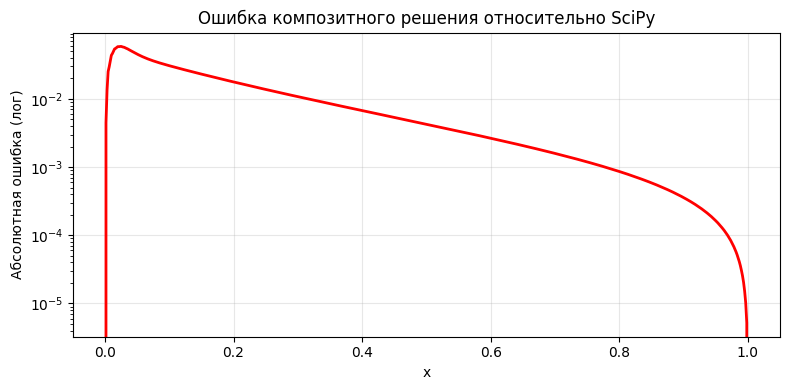

In [3]:
# Ошибка композитного решения относительно SciPy
Xc = np.linspace(0.0, 1.0, 600)
yc = y_comp(Xc, EPS, A, B)
yc_sci = np.interp(Xc, x_sci, y_sci)
err = np.abs(yc - yc_sci)

plt.figure(figsize=(8, 4))
plt.semilogy(Xc, err, 'r-', linewidth=2)
plt.xlabel('x')
plt.ylabel('Абсолютная ошибка (лог)')
plt.title('Ошибка композитного решения относительно SciPy')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [4]:
# Таблица сравнения в нескольких точках x
x_points = [0.0, 0.02, 0.05, 0.1, 0.3, 0.5, 0.8, 1.0]
rows = []
for xv in x_points:
    rows.append({
        'x': xv,
        'comp': y_comp(xv, EPS, A, B),
        'prog': float(np.interp(xv, x_num, y_num)),
        'scipy': float(np.interp(xv, x_sci, y_sci)),
    })

df = pd.DataFrame(rows)
df['er(comp)'] = np.abs(df['comp'] - df['scipy'])
df['er(prog)'] = np.abs(df['prog'] - df['scipy'])
display(df.round(6))


x      comp      prog     scipy  er(comp)  er(prog)
0  0.00  0.000000  0.000000  0.000000  0.000000  0.000000
1  0.02  2.478610  2.537190  2.537076  0.058467  0.000114
2  0.05  2.707059  2.752565  2.752554  0.045495  0.000012
3  0.10  2.499864  2.530568  2.530569  0.030705  0.000001
4  0.30  1.875000  1.885787  1.885788  0.010788  0.000001
5  0.50  1.500000  1.504250  1.504251  0.004251  0.000001
6  0.80  1.153846  1.154707  1.154708  0.000861  0.000000
7  1.00  1.000000  1.000000  1.000000  0.000000  0.000000

eps      comp     scipy  err(comp)
0  0.001  1.500000  1.500418   0.000418
1  0.005  1.500000  1.502104   0.002104
2  0.010  1.500000  1.504251   0.004251
3  0.020  1.500000  1.508678   0.008678
4  0.050  1.499864  1.523222   0.023358
5  0.100  1.479786  1.551910   0.072124

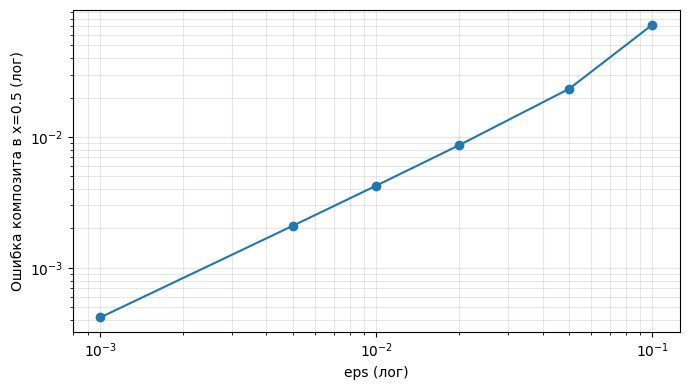

In [5]:
# Ошибка vs eps (в фиксированной точке x=0.5)
EPS_LIST = [1e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1]
rows = []
for e in EPS_LIST:
    xs, ys = solve_scipy(e, A, B)
    yc = y_comp(0.5, e, A, B)
    ysci = float(np.interp(0.5, xs, ys))
    rows.append({'eps': e, 'comp': yc, 'scipy': ysci, 'err(comp)': abs(yc - ysci)})

df_eps = pd.DataFrame(rows)
display(df_eps.round(8))

plt.figure(figsize=(7,4))
plt.loglog(df_eps['eps'], df_eps['err(comp)'], 'o-')
plt.xlabel('eps (лог)')
plt.ylabel('Ошибка композита в x=0.5 (лог)')
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()
